In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns
import re
from io import StringIO

sns.set_palette("husl")
sns.set_style("whitegrid")

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [2]:
#dataset = "initial"
dataset = "incremental"
references_algorithms = ["Boost Kruskal", "Boost Prim"]

filenames = glob.glob(f"data/{dataset}/*/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

def remove_space(filename):
    with open(filename) as f:
        return re.sub(" +", ' ', f.read())

files = [StringIO(remove_space(filename)) for filename in filenames]

In [4]:
def get_df(file):
    return (pd
      .read_csv(file, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(file) for file in files)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)
df['Graph'] = df.apply(lambda x: (x['Graph name'], x['Graph nodes']), 1)
df["Throughput"] = 1/df["time"]
for ref in references_algorithms:
    reference_times = df[(df.Algorithm == ref) & (df['Max threads'] == 1)][["Graph", "time"]].groupby('Graph').median()['time']
    df[f'{ref} speedup'] = df.apply(lambda x: reference_times[x.Graph] / x.time if x.Graph in reference_times.index else None , 1)
df['speedup'] = df.apply(lambda x: df[(df.Algorithm == x.Algorithm) & (df.Graph == x.Graph) & (df['Max threads'] == 1)].time.median() / x.time, 1)

In [ ]:
s = df[["Algorithm", "Graph", "Max threads", "speedup", "time"]]\
    .groupby(("Graph", "Algorithm", "Max threads"))\
    .agg(["median", "std"])
s.time.to_csv(f"summaries/{dataset}/time_summary.csv")
s.time.to_latex(f"summaries/{dataset}/time_summary.tex")
s.speedup.to_csv(f"summaries/{dataset}/speedup_summary.csv")
s.speedup.to_latex(f"summaries/{dataset}/speedup_summary.tex")

In [ ]:
df.head(5)

In [ ]:
df.tail(5)

In [ ]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [ ]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [ ]:
summary

In [ ]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="time", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/Graph_runtime.png", dpi=450)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=len(df["Algorithm"].unique()),figsize=(15,5*len(df["Algorithm"].unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi,
        data=df[df["Algorithm"].values == e], 
        x="Graph nodes", 
        y="time", 
        hue="Max threads",
        markers=True,
        ci="sd",
        err_style="bars",
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df["Algorithm"].values == e]["time"]), np.max(df[df["Algorithm"].values == e]["time"])])
    axi.set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    axi.set_title(f"{e}")
plt.suptitle("Runtime per algorithm")
fig.savefig(f"figures/{dataset}/AlgoRuntime.png", dpi=450)
plt.show()

In [ ]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

In [ ]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/ViolinRuntime.png", dpi=450)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df.Graph == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    mi, ma = np.log10([np.min(df[df.Graph == e]["time"]), np.max(df[df.Graph == e]["time"])])
    ax[i].set_yticks(10**np.arange(np.round(mi, 1), np.round(ma, 1), .1))
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
plt.suptitle("Runtime per graph")
fig.savefig(f"figures/{dataset}/BoxRuntime.png", dpi=450)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="Throughput", 
        hue="Algorithm",
        markers=True,
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    #ax[i].set_ylim(1,)
    ax[i].set_xticks(2**np.arange(0, 6, 1))
plt.suptitle("Throughput per graph")
fig.savefig(f"figures/{dataset}/Throughput.png", dpi=450)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=len(df.Algorithm.unique()),figsize=(15,5*len(df.Algorithm.unique())))
for i, e in enumerate(df["Algorithm"].unique()):
    axi = ax[i] if len(df["Algorithm"].unique()) > 1 else ax
    sns.lineplot(
        ax=axi, 
        data=df[df.Algorithm == e], 
        x="Graph nodes", 
        y="Reference speedup", 
        hue="Max threads",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    axi.set_title(f"{e}")
    axi.set_ylim(0,)
plt.suptitle(f"Speedup per graph against {reference_algorithm}")
r_name = reference_algorithm.replace(' ', '_')
fig.savefig(f"figures/{dataset}/Speedup_against_{r_name}.png", dpi=450)
plt.show()

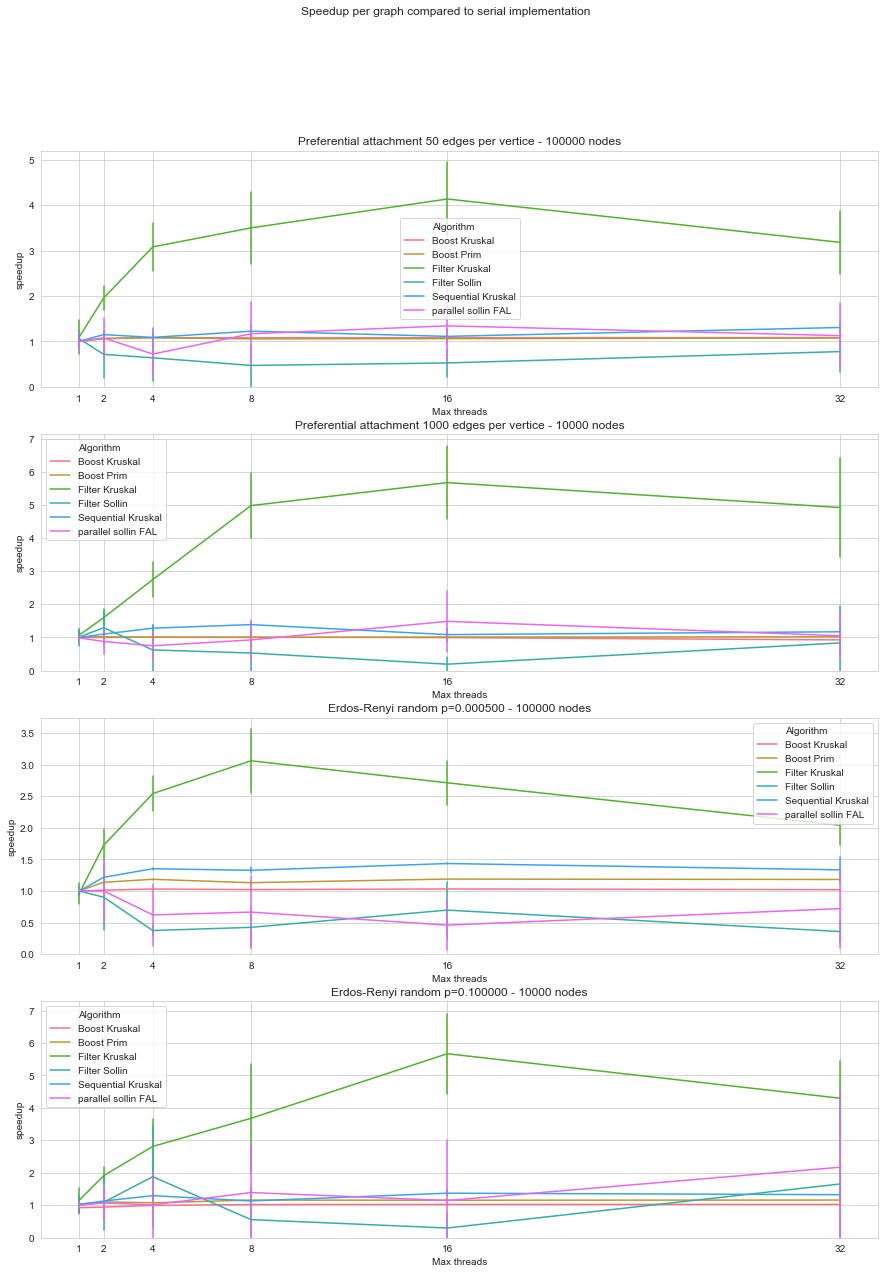

In [5]:
fig, ax = plt.subplots(nrows=len(df.Graph.unique()),figsize=(15,5*len(df.Graph.unique())))
for i, e in enumerate(df.Graph.unique()):
    sns.lineplot(
        ax=ax[i], 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="speedup", 
        hue="Algorithm",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    ax[i].set_xticks(2**np.arange(0, 6, 1))
    ax[i].set_title(f"{e[0]} - {e[1]} nodes")
    ax[i].set_ylim(0,)
plt.suptitle(f"Speedup per graph compared to serial implementation")
fig.savefig(f"figures/{dataset}/Speedup.png", dpi=450)
plt.show()

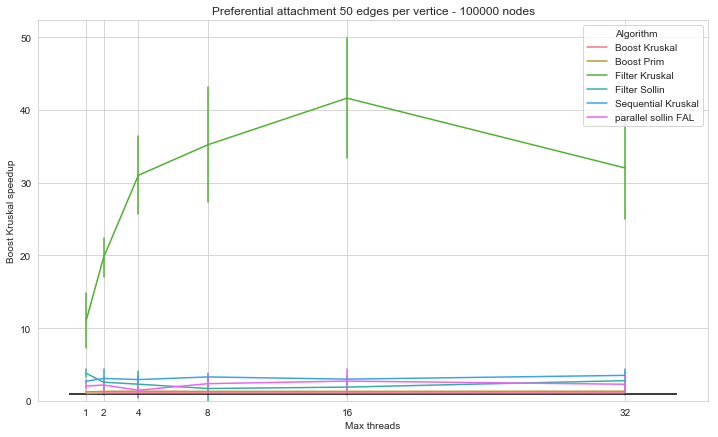

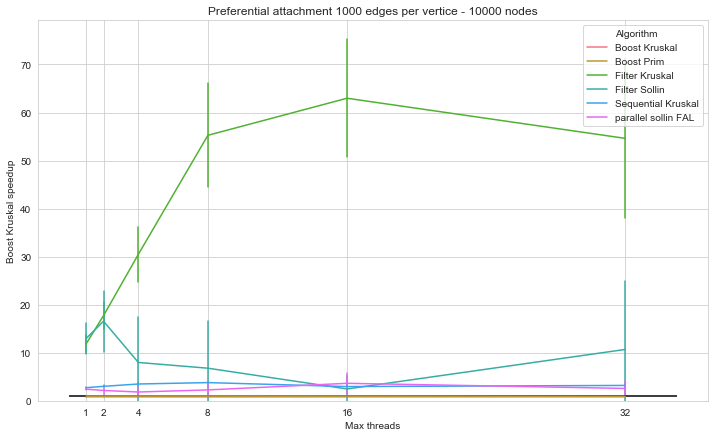

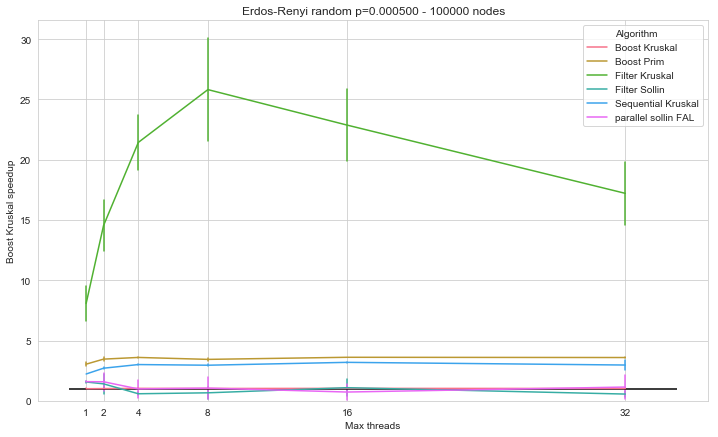

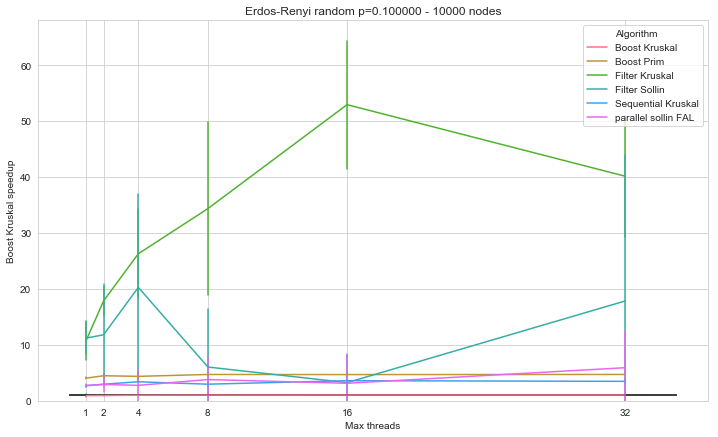

In [28]:
for i, e in enumerate(df.Graph.unique()):
    fig, ax = plt.subplots(figsize=(12, 7))
    #e = ('Preferential attachment 50 edges per vertice', 100000)
    sns.lineplot(
        ax=ax, 
        data=df[df.Graph == e], 
        x="Max threads", 
        y="Boost Kruskal speedup", 
        hue="Algorithm",
        ci="sd",
        err_style="bars",
    )#.set(yscale="log")
    plt.hlines(y=1, xmin=0, xmax=35)
    ax.set_xticks(2**np.arange(0, 6, 1))
    ax.set_title(f"{e[0]} - {e[1]} nodes")
    ax.set_ylim(0,)
    fig.savefig(f"../presentations/final/graphics/BoostKruskalSpeedup{i}.png", dpi=450)
    plt.show()